In [1]:
import pandas as pd
from pandas_datareader import data, wb
import datetime

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
start = pd.to_datetime('2015-09-24')
end = pd.to_datetime('today')
data_df = data.DataReader('TSLA','yahoo',start,end)
data_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-24,52.689999,51.242001,51.905998,52.624001,17241000.0,52.624001
2015-09-25,53.382000,51.230000,53.321999,51.382000,18867000.0,51.382000
2015-09-28,51.958000,49.321999,51.470001,49.686001,24505500.0,49.686001
2015-09-29,50.945999,49.091999,50.091999,49.330002,18516000.0,49.330002
2015-09-30,50.480000,48.467999,50.400002,49.680000,24648000.0,49.680000
...,...,...,...,...,...,...
2020-09-18,451.000000,428.799988,447.940002,442.149994,86406800.0,442.149994
2020-09-21,455.679993,407.070007,453.130005,449.390015,109476800.0,449.390015
2020-09-22,437.760010,417.600006,429.600006,424.230011,79580800.0,424.230011


In [5]:
df1=data_df.reset_index()['Close']
df1

0        52.624001
1        51.382000
2        49.686001
3        49.330002
4        49.680000
           ...    
1255    442.149994
1256    449.390015
1257    424.230011
1258    380.359985
1259    392.780090
Name: Close, Length: 1260, dtype: float64

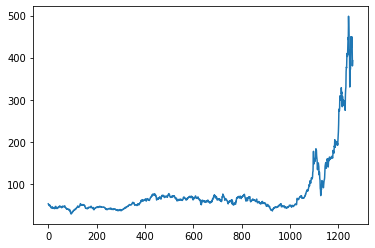

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
import numpy as np
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.0508746 ],
       [0.04822972],
       [0.04461803],
       ...,
       [0.84222273],
       [0.74879996],
       [0.77524902]])

In [11]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
training_size,test_size

(1008, 252)

In [13]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(907, 100)
(907,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(151, 100)
(151,)


(None, None)

In [17]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 79ms/step - loss: 6.4055e-04 - val_loss: 0.0809
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 2.3519e-04 - val_loss: 0.0469
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 1.3880e-04 - val_loss: 0.0200
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 9.2863e-05 - val_loss: 0.0204
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 8.5141e-05 - val_loss: 0.0199
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 8.3710e-05 - val_loss: 0.0190
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: 7.9874e-05 - val_loss: 0.0157
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 8.7660e-05 - val_loss: 0.0184
Epoch 9/100
15/15 [==============================] - 0s 17ms/step - loss: 8.3429e-05 - val_loss: 0.0176
Epoch 10/100
15/15 [==============================] - 0s 15ms/st

In [22]:
import tensorflow as tf

tf.__version__

'2.3.0'

In [23]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [24]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

6.3411397689108995

In [26]:
math.sqrt(mean_squared_error(ytest,test_predict))

42.575894333585104

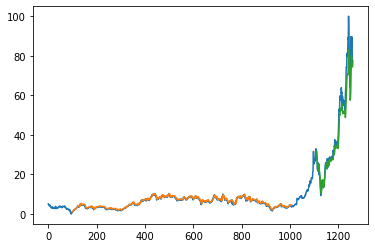

In [27]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [28]:

len(test_data)

252

In [29]:
x_input=test_data[152:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.2659959983721903,
 0.2721163003601296,
 0.2710344732708948,
 0.2878067086967685,
 0.2843440691544311,
 0.28354338128293155,
 0.2756853906742308,
 0.2809538590291455,
 0.27918208406541084,
 0.28534069663329814,
 0.28294711398687955,
 0.2861627006544549,
 0.29129063189463256,
 0.2867249141016643,
 0.28757245850945307,
 0.2881516988810837,
 0.2820101132376177,
 0.29444233510149737,
 0.3213170607114122,
 0.3142725606616575,
 0.3148688279577095,
 0.3069554998446395,
 0.31601879523876014,
 0.3433875616099378,
 0.3394479407248894,
 0.37538596172892486,
 0.3531493508348995,
 0.337152295388024,
 0.36084123144810065,
 0.35710603113849987,
 0.36122030797538907,
 0.36640360921406656,
 0.3651003021308323,
 0.36229784583938796,
 0.3654751219270154,
 0.34804273574437916,
 0.35874578244970806,
 0.34756997863864286,
 0.3686992220568014,
 0.3987086564432902,
 0.4156682530260596,
 0.45358675879451305,
 0.522975570071848,
 0.5307610987693665,
 0.5205478685883257,
 0.5326436137301008,
 0.596687270504364

In [34]:
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<11):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day Prediction {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)
#for i in lst_output:


0 day Prediction [[0.29443455]]
1 day Prediction [[0.2894227]]
2 day Prediction [[0.28471306]]
3 day Prediction [[0.28028116]]
4 day Prediction [[0.27608597]]
5 day Prediction [[0.27207947]]
6 day Prediction [[0.26821482]]
7 day Prediction [[0.2644522]]
8 day Prediction [[0.26076165]]
9 day Prediction [[0.25712433]]
10 day Prediction [[0.25353193]]
[[0.2944345474243164], [0.2894226908683777], [0.2847130596637726], [0.2802811563014984], [0.2760859727859497], [0.2720794677734375], [0.2682148218154907], [0.264452189207077], [0.26076164841651917], [0.2571243345737457], [0.25353193283081055]]
